### The majority of the code has been sourced from this tutorial
Source: https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

In [39]:
from fastai.vision import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import imageio
import re
import os
from sklearn.model_selection import train_test_split

import urllib.request
from urllib.error import HTTPError

import PIL

import requests

import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

### Bechdel Test and Film Poster Analysis
In this notebook, we will read in data from two different data sets. One being a JSON files of the Bechdel data and the other being a CSV of films information and JPG URL data

In [5]:
data = pd.read_csv('data/MovieGenre.csv',engine='python')

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [6]:
betchel_df = pd.read_json('data/betchel.json')

In [8]:
## Remove empty string values - sometimes hidden files after several runs
betchel_df = betchel_df[betchel_df.imdbid != ""]

In [9]:
# all the imdbIDs that we have results for
# finding the intersection of the IMDbID values between both data sets
all_bech_post = np.intersect1d(betchel_df["imdbid"].astype(int), data["imdbId"]) 

betchel_df['imdbid'] = betchel_df["imdbid"].astype(int)
betchel_df = betchel_df.rename({'imdbid': 'imdbId'}, axis = 1)

In [40]:
# Because the order in the other data set is not correct, matching the IMDb ID with the 
# score that film has - also chaning the values so that each score is either a one or zero value
imdb = []
score = []
for i in range(len(all_bech_post)):
    imdb.append(all_bech_post[i])
    if(betchel_df['rating'][i] > 2):
        score.append(1)
    else:
        score.append(0)
betchel_comp = pd.DataFrame({"imdbId": imdb, "score": score})

In [41]:

with_bech = data.loc[data['imdbId'].isin(all_bech_post)]

match_score = []
for i in range(len(with_bech.imdbId)):
    match_score.append(betchel_comp[betchel_comp.imdbId == with_bech.imdbId.iloc[i]].score.values[0])
    
with_bech['score'] = match_score

<ipython-input-41-e44cb6c4c011>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_bech['score'] = match_score


In [42]:
with_bech = with_bech.dropna()

In [43]:
train, test = train_test_split(with_bech, test_size=0.2, random_state=42, shuffle=True)

## WARNING: Long Run Time - Might Break Kernel!

In [ ]:
import urllib.request
err = 0

#### TRAINING SET
for i in range(len(train.score)):
    if(train.score.iloc[i] == 0):
        try:
            urllib.request.urlretrieve(train.Poster.iloc[i], 
                                       "data/train/fail/" + str(train.imdbId.iloc[i]) + "fail" + ".jpg")
        except:
            err += 1
            print("Http err")
    elif(train.score.iloc[i] == 1):
        try:
            urllib.request.urlretrieve(train.Poster.iloc[i], 
                                       "data/train/pass/" + str(train.imdbId.iloc[i]) + "pass" + ".jpg")
        except:
            err += 1
            print("Http err")
            
            
### TESTING SET
for i in range(len(test.score)):
    if(test.score.iloc[i] == 0):
        try:
            urllib.request.urlretrieve(test.Poster.iloc[i], 
                                       "data/test/fail/" + str(test.imdbId.iloc[i]) + "fail" + ".jpg")
        except:
            err += 1
            print("Http err")
    elif(test.score.iloc[i] == 1):
        try:
            urllib.request.urlretrieve(test.Poster.iloc[i], `
                                       "data/test/pass/" + str(test.imdbId.iloc[i]) + "pass" + ".jpg")
        except:
            err += 1
            print("Http err")

In [23]:
import cv2
import os
labels = ['pass', 'fail']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                if(img != ".DS_Store"):
                    img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return (data)

In [24]:
train = get_data('data/train/')
val = get_data('data/test/')
#Now we can easily fetch our train and validation data.
#train = get_data('../input/traintestsports/Main/train')
#val = get_data('../input/traintestsports/Main/test')

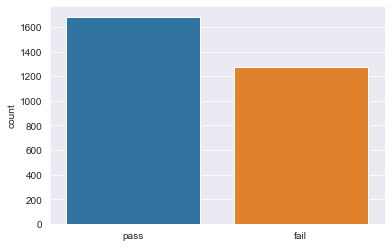

In [25]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("pass")
    else:
        l.append("fail")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'pass')

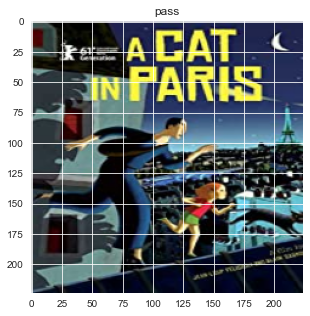

In [26]:
plt.figure(figsize = (5,5))
plt.imshow(train[1244][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'fail')

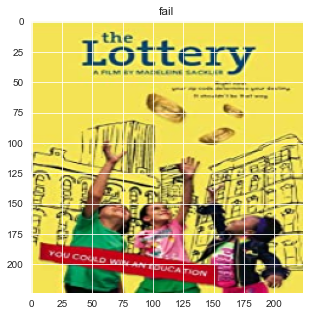

In [27]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1224][0])
plt.title(labels[train[-13][1]])

Normalizing and reshaping the data so that it is able to be modeled by the CNN

In [28]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

Building the CNN model: 

In [30]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)       

In [31]:
opt = Adam(lr=0.00001)
model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

### NOTE: depending on the computing power of your system, increase the size of epochs below

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs = 5 , validation_data = (x_val, y_val))

Epoch 1/5
93/93 [==============================] - 309s 3s/step - loss: 0.6961 - accuracy: 0.4261 - val_loss: 0.6853 - val_accuracy: 0.4239
Epoch 2/5
93/93 [==============================] - 277s 3s/step - loss: 0.6798 - accuracy: 0.4258 - val_loss: 0.6853 - val_accuracy: 0.4239
Epoch 3/5
93/93 [==============================] - 246s 3s/step - loss: 0.6746 - accuracy: 0.4229 - val_loss: 0.6935 - val_accuracy: 0.4239
Epoch 4/5
93/93 [==============================] - 175s 2s/step - loss: 0.6668 - accuracy: 0.4332 - val_loss: 0.6877 - val_accuracy: 0.4239
Epoch 5/5
93/93 [==============================] - 204s 2s/step - loss: 0.6528 - accuracy: 0.4255 - val_loss: 0.6963 - val_accuracy: 0.4239


To display the results we plot the Training and Validation Loss as well as the training and validation accuracy.

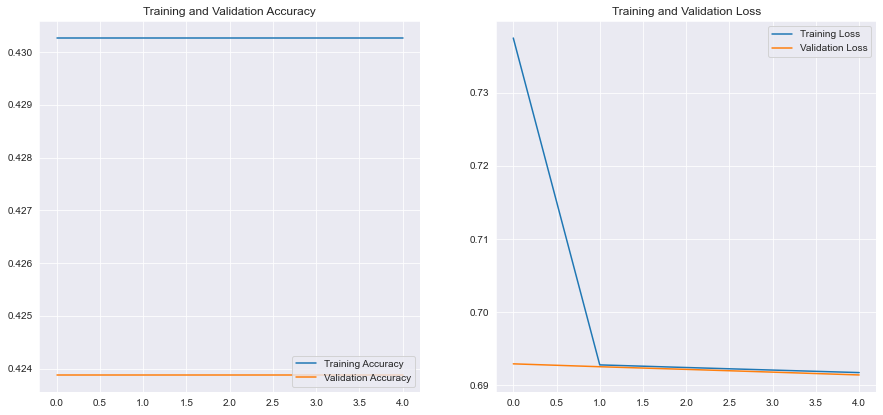

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()